# Simple Example

In [1]:
import sys
sys.path.append('../../../notebooks')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt

from raimitigations.utils import split_data, train_model_plot_results
from raimitigations.dataprocessing import (
    Rebalance,
    EncoderOrdinal,
    EncoderOHE,
    BasicImputer,
    SeqFeatSelection,
    CatBoostSelection,
    Synthesizer,
    Rebalance
)
from download import download_datasets

In [2]:
data_dir = '../../../datasets/'
download_datasets(data_dir)
dataset =  pd.read_csv(data_dir + 'hr_promotion/train.csv')
dataset.drop(columns=['employee_id'], inplace=True)
label_col = 'is_promoted'
dataset

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54803,Technology,region_14,Bachelor's,m,sourcing,1,48,3.0,17,0,0,78,0
54804,Operations,region_27,Master's & above,f,other,1,37,2.0,6,0,0,56,0
54805,Analytics,region_1,Bachelor's,m,other,1,27,5.0,3,1,0,79,0
54806,Sales & Marketing,region_9,NaN,m,sourcing,1,29,1.0,2,0,0,45,0


## 1 - Base Model

Split the data into training and test sets.

In [3]:
train_x, test_x, train_y, test_y = split_data(dataset, label_col, test_size=0.2)
org_train_x = train_x.copy()
org_train_y = train_y.copy()
org_test_x = test_x.copy()
org_test_y = test_y.copy()
train_x

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
24496,Operations,region_22,Master's & above,f,sourcing,2,36,4.0,6,0,0,62
16116,Technology,region_22,Bachelor's,f,other,2,27,1.0,3,0,0,81
19465,Analytics,region_31,Bachelor's,m,other,1,37,1.0,7,0,0,81
40882,Technology,region_5,Bachelor's,f,other,1,24,NaN,1,1,0,82
28411,Sales & Marketing,region_2,NaN,m,sourcing,2,38,4.0,9,0,0,53
...,...,...,...,...,...,...,...,...,...,...,...,...
26819,Procurement,region_2,Master's & above,m,other,2,49,3.0,12,0,0,69
26467,Technology,region_16,Master's & above,f,other,1,36,4.0,8,1,0,81
942,Operations,region_23,Master's & above,f,other,1,41,5.0,13,1,0,62
33606,Procurement,region_17,Bachelor's,m,sourcing,2,31,NaN,1,0,0,70


Many models can't handle categorical data and missing values, so we cannot train the model just yet. First we need to encode all categorical data and remove missing values.

In [4]:
imputer = BasicImputer(specific_col={'previous_year_rating': {	'missing_values':np.nan, 
																'strategy':'constant', 
																'fill_value':-100 } } )
encoder = EncoderOrdinal(categories={'education': ["Below Secondary", "Bachelor's", "Master's & above"]})

imputer.fit(train_x)
train_x = imputer.transform(train_x)
test_x = imputer.transform(test_x)

train_x

No columns specified for imputation. These columns have been automatically identified:
['education', 'previous_year_rating']


,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
24496,Operations,region_22,Master's & above,f,sourcing,2,36,4.0,6,0,0,62
16116,Technology,region_22,Bachelor's,f,other,2,27,1.0,3,0,0,81
19465,Analytics,region_31,Bachelor's,m,other,1,37,1.0,7,0,0,81
40882,Technology,region_5,Bachelor's,f,other,1,24,-100.0,1,1,0,82
28411,Sales & Marketing,region_2,NULL,m,sourcing,2,38,4.0,9,0,0,53
...,...,...,...,...,...,...,...,...,...,...,...,...
26819,Procurement,region_2,Master's & above,m,other,2,49,3.0,12,0,0,69
26467,Technology,region_16,Master's & above,f,other,1,36,4.0,8,1,0,81
942,Operations,region_23,Master's & above,f,other,1,41,5.0,13,1,0,62
33606,Procurement,region_17,Bachelor's,m,sourcing,2,31,-100.0,1,0,0,70


In [5]:
encoder.fit(train_x)
train_x = encoder.transform(train_x)
test_x = encoder.transform(test_x)
train_x

No columns specified for encoding. These columns have been automatically identfied as the following:
['department', 'region', 'education', 'gender', 'recruitment_channel']


,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
24496,4,14,2,0,2,2,36,4.0,6,0,0,62
16116,8,14,1,0,0,2,27,1.0,3,0,0,81
19465,0,24,1,1,0,1,37,1.0,7,0,0,81
40882,8,29,1,0,0,1,24,-100.0,1,1,0,82
28411,7,11,-1,1,2,2,38,4.0,9,0,0,53
...,...,...,...,...,...,...,...,...,...,...,...,...
26819,5,11,2,1,0,2,49,3.0,12,0,0,69
26467,8,7,2,0,0,1,36,4.0,8,1,0,81
942,4,15,2,0,0,1,41,5.0,13,1,0,62
33606,5,8,1,1,2,2,31,-100.0,1,0,0,70


 Now we create the model and train it using the training set. In the sequence, test its performance over the test set. 

------------
TEST
------------


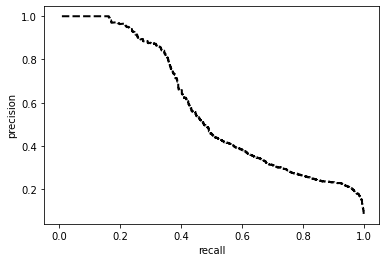

[[7082 2946]
 [  68  866]]


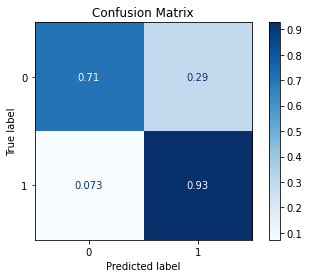

Acuracy: 72.51%

Precision:  0.6088334226109672

Recall:  0.8167087187993533

F1 =  0.5947409580271947

ROC AUC =  0.8975844081966639


In [6]:
model = train_model_plot_results(train_x, train_y, test_x, test_y, model="xgb", train_result=False)

## 2 - Feature Selection

In [7]:
from sklearn.neighbors import KNeighborsClassifier

feat_sel = SeqFeatSelection(scoring='f1', n_jobs=4)
feat_sel.fit(X=train_x, y=train_y)
feat_sel.get_selected_features()

No columns specified for imputation. These columns have been automatically identified:
[]
No columns specified for encoding. These columns have been automatically identfied as the following:
[]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:    0.9s finished

[2022-10-13 16:31:23] Features: 1/12 -- score: 0.19148759039154736[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  11 out of  11 | elapsed:    0.2s finished

[2022-10-13 16:31:23] Features: 2/12 -- score: 0.48577006489935365[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.3s finished

[2022-10-13 16:31:24] Features: 3/12 -- score: 0.4904928857500482[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of   9 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   9 out of   9 | elapsed:    0.2s finished

[2022-10-13 16:31:24] Features: 4/12 -- score: 0.4860887248

['department', 'awards_won?', 'avg_training_score']

In [8]:
train_x = feat_sel.transform(train_x)
test_x = feat_sel.transform(test_x)
train_x

,department,awards_won?,avg_training_score
24496,4,0,62
16116,8,0,81
19465,0,0,81
40882,8,0,82
28411,7,0,53
...,...,...,...
26819,5,0,69
26467,8,0,81
942,4,0,62
33606,5,0,70


------------
TEST
------------


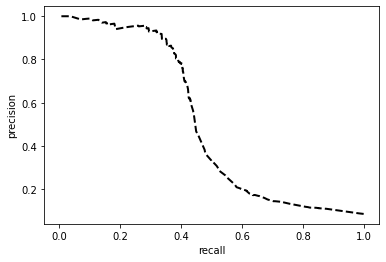

[[8940 1088]
 [ 451  483]]


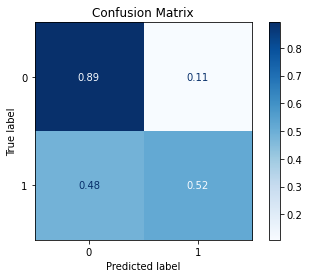

Acuracy: 85.96%

Precision:  0.6297113905867997

Recall:  0.7043172051873599

F1 =  0.6531882319094238

ROC AUC =  0.7545332917936843


In [9]:
model = train_model_plot_results(train_x, train_y, test_x, test_y, model="xgb", train_result=False)

## 3 - Generating Synthetic Data + Feature Selection

In [10]:
dataset[label_col].value_counts(normalize=True)

0    0.91483
1    0.08517
Name: is_promoted, dtype: float64

In [11]:
train_df = org_train_x.copy()
train_df[label_col] = org_train_y
test_x = org_test_x
test_y = org_test_y

train_df[label_col].value_counts(normalize=True)

0    0.914838
1    0.085162
Name: is_promoted, dtype: float64

In [12]:
synth = Synthesizer(
				df=train_df,
				label_col=label_col,
				model='ctgan',
				epochs=150,
				load_existing=False
			)
synth.fit()
balance_train = synth.transform(df=train_df, strategy=0.3)
balance_train[label_col].value_counts(normalize=True)

/home/mmendonca/anaconda3/envs/rai/lib/python3.9/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/mmendonca/anaconda3/envs/rai/lib/python3.9/site-packages/sklearn/mixture/_base.py:131: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  cluster.KMeans(
/home/mmendonca/anaconda3/envs/rai/lib/python3.9/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/mmendonca/anaconda3/envs/rai/lib/python3.9/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/

0    0.76924
1    0.23076
Name: is_promoted, dtype: float64

No columns specified for imputation. These columns have been automatically identified:
['education', 'previous_year_rating']
No columns specified for encoding. These columns have been automatically identfied as the following:
['department', 'region', 'education', 'gender', 'recruitment_channel']
------------
TEST
------------


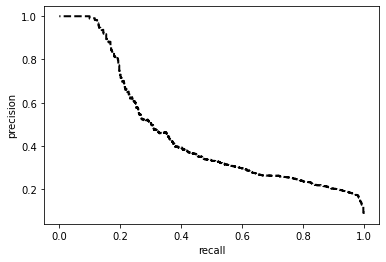

[[6954 3074]
 [ 110  824]]


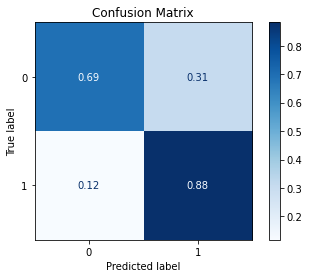

Acuracy: 70.95%

Precision:  0.5979092713573241

Recall:  0.7878426487206271

F1 =  0.5773868104515802

ROC AUC =  0.8685455884124025


In [13]:
train_x = balance_train.drop(columns=[label_col])
train_y = balance_train[label_col]

imputer = BasicImputer(specific_col={'previous_year_rating': {	'missing_values':np.nan, 
																'strategy':'constant', 
																'fill_value':-100 } } )
encoder = EncoderOrdinal(categories={'education': ["Below Secondary", "Bachelor's", "Master's & above"]})

imputer.fit(train_x)
train_x = imputer.transform(train_x)
test_x = imputer.transform(test_x)

encoder.fit(train_x)
train_x = encoder.transform(train_x)
test_x = encoder.transform(test_x)

model = train_model_plot_results(train_x, train_y, test_x, test_y, model="xgb", train_result=False)

No columns specified for imputation. These columns have been automatically identified:
[]
No columns specified for encoding. These columns have been automatically identfied as the following:
[]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:    1.2s finished

[2022-10-13 16:46:05] Features: 1/12 -- score: 0.18157051690346274[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  11 out of  11 | elapsed:    0.2s finished

[2022-10-13 16:46:05] Features: 2/12 -- score: 0.2425749257156059[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.4s finished

[2022-10-13 16:46:06] Features: 3/12 -- score: 0.44256586040799356[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of   9 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   9 out of   9 | elapsed:    0.6s finished

[2022-10-13 16:46:07] Features: 4/12 -- score: 0.4492790681

SELECTED FEATURES: ['department', 'region', 'no_of_trainings', 'KPIs_met >80%', 'awards_won?', 'avg_training_score']
------------
TEST
------------


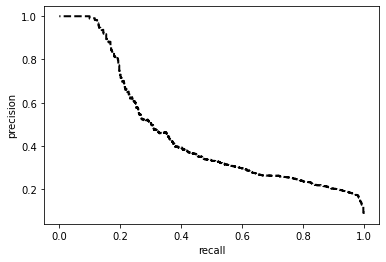

[[6954 3074]
 [ 110  824]]


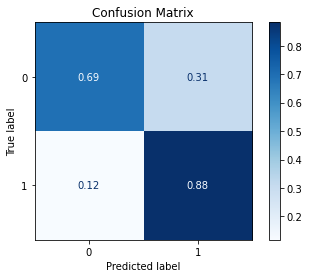

Acuracy: 70.95%

Precision:  0.5979092713573241

Recall:  0.7878426487206271

F1 =  0.5773868104515802

ROC AUC =  0.8685455884124025


In [14]:
feat_sel = SeqFeatSelection(scoring='f1', n_jobs=4)
feat_sel.fit(X=train_x, y=train_y)
print(f"SELECTED FEATURES: {feat_sel.get_selected_features()}")
train_x_feat = feat_sel.transform(train_x)
test_x_feat = feat_sel.transform(test_x)
model = train_model_plot_results(train_x, train_y, test_x, test_y, model="xgb", train_result=False)

## 4 - Feature Selection + Synthetic Data

No columns specified for imputation. These columns have been automatically identified:
['education', 'previous_year_rating']
No columns specified for encoding. These columns have been automatically identfied as the following:
['department', 'region', 'education', 'gender', 'recruitment_channel']
SELECTED FEATURES: ['awards_won?', 'avg_training_score', 'department_Finance', 'department_HR', 'department_Legal', 'department_Operations', 'department_Procurement', 'department_R&D', 'department_Sales & Marketing', 'department_Technology', 'region_region_15', 'region_region_19', 'region_region_30', 'region_region_4']
------------
TEST
------------


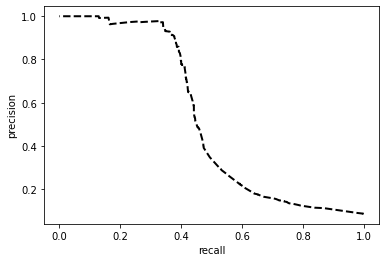

[[9535  493]
 [ 502  432]]


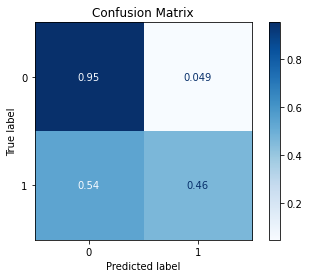

Acuracy: 90.92%

Precision:  0.708506041161217

Recall:  0.7066822105812505

F1 =  0.7075885834727292

ROC AUC =  0.7621570736840485


In [15]:
train_x = org_train_x
train_y = org_train_y
test_x = org_test_x
test_y = org_test_y

imputer = BasicImputer(specific_col={'previous_year_rating': {	'missing_values':np.nan, 
																'strategy':'constant', 
																'fill_value':-100 } } )
encoder = EncoderOHE()

feat_sel = SeqFeatSelection(scoring='f1', transform_pipe=[imputer, encoder], n_jobs=4, verbose=False)
feat_sel.fit(X=train_x, y=train_y)
print(f"SELECTED FEATURES: {feat_sel.get_selected_features()}")

train_x = feat_sel.transform(train_x)
test_x = feat_sel.transform(test_x)

model = train_model_plot_results(train_x, train_y, test_x, test_y, model="xgb", train_result=False)

In [16]:
train_df = train_x
train_df[label_col] = train_y
test_df = test_x
test_df[label_col] = test_y

synth = Synthesizer(
				df=train_df,
				label_col=label_col,
				model='ctgan',
				epochs=130,
				load_existing=False
			)
synth.fit()
balance_train = synth.transform(df=train_df, strategy=0.3)
balance_train[label_col].value_counts(normalize=True)

/home/mmendonca/anaconda3/envs/rai/lib/python3.9/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/mmendonca/anaconda3/envs/rai/lib/python3.9/site-packages/ctgan/data_transformer.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column_name] = data[column_name].to_numpy().flatten()
Sampling conditions: 100%|██████████| 8299/8299 [00:02<00:00, 2858.88it/s]


0    0.76924
1    0.23076
Name: is_promoted, dtype: float64

------------
TEST
------------


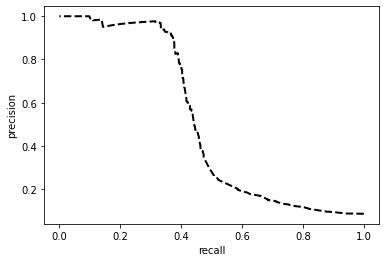

[[9565  463]
 [ 512  422]]


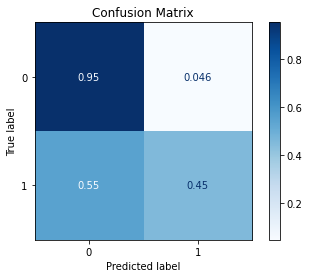

Acuracy: 91.11%

Precision:  0.7130136928699858

Recall:  0.7028247032505985

F1 =  0.7077479024018898

ROC AUC =  0.7372637663791918


In [17]:
train_x = balance_train.drop(columns=[label_col])
train_y = balance_train[label_col]
test_x = test_df.drop(columns=[label_col])
test_y = test_df[label_col]

model = train_model_plot_results(train_x, train_y, test_x, test_y, model="xgb", train_result=False)